In [26]:
import numpy as np
from scipy.signal import peak_widths
from tqdm import tqdm
from math import sqrt,exp
import matplotlib
from matplotlib import pyplot as plt
from multiprocessing import Pool
from itertools import product
from itertools import combinations
from qutip import *
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
settings.num_cpus = 100
font = {'size'   : 17}
matplotlib.rc('font', **font)
matplotlib.rcParams['text.usetex'] = True
plt.rcParams["figure.figsize"]= 5, 4
plt.rcParams['figure.dpi'] = 90
matplotlib.rcParams['lines.linewidth'] = 2
plt.rcParams['axes.grid'] = False
plt.rcParams['axes.grid.which'] = "both"
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

### Creating Hamiltonian manually

In [27]:
def get_basis(Ek_0):
    sing_basis = ['0u', '0d']
    for i in range(1, len(Ek_0)+1):
        sing_basis +=  [str(i)+'u', str(i)+'d']
    basis = []
    for i in range(2*len(Ek_0)+3):
        basis += combinations(sing_basis, i)
    return basis

    
    
def diag(Ek_0, V, U):
    basis = get_basis(Ek_0)
    H = np.zeros([len(basis)]*2)
    for i, state in enumerate(basis):
        if ('0u' in state and '0d' in state) or ('0u' not in state and '0d' not in state):
            H[i][i] += U/4
        else:
            H[i][i] -= U/4
        for k in range(1, len(Ek_0)+1):
            if str(k)+'u' not in state and str(k)+'d' not in state:
                H[i][i] -= Ek_0[k-1]
            elif str(k)+'u' in state and str(k)+'d' in state:
                H[i][i] += Ek_0[k-1]
    return H


def off_diag(Ek_0, V, U):
    basis = get_basis(Ek_0)
    H = np.zeros([len(basis)]*2)
    for k in range(1, len(Ek_0)+1):
        for (i, si), (j, sj) in product(enumerate(basis), enumerate(basis)):
            si = list(si)
            sj = list(sj)
            if i==j or si == () or sj == ():
                continue
            if set(si + [str(k)+'u']) == set(sj + ['0u']) or set(sj + [str(k)+'u']) == set(si + ['0u']):
                H[i][j] = V
            if set(si + [str(k)+'d']) == set(sj + ['0d']) or set(sj + [str(k)+'d']) == set(si + ['0d']):
                H[i][j] = V
    return H
        
    
def get_nd(Ek_0):
    basis = get_basis(Ek_0)
    nd_up = np.zeros([len(basis)]*2)
    nd_dn = np.zeros([len(basis)]*2)
    for i, state in enumerate(basis):
        if '0u' in state:
            nd_up [i][i] = 1
        if '0d' in state:
            nd_dn [i][i] = 1
    return nd_up, nd_dn

### Creating Hamiltonian using Qutip

In [28]:
def get_ham(Ek_0, V, ed, U):
    H_d = 0
    H_k = 0
    H_v = 0
    dim = len(Ek_0)
    numop = create(2)*destroy(2)
    cop = destroy(2)
    H_d += ed*tensor([numop, identity(2)] + [identity(2)]*2*dim)
    H_d += ed*tensor([identity(2), numop] + [identity(2)]*2*dim)
    H_d += U*tensor([numop, numop] + [identity(2)]*2*dim)
    for i in range(dim):
        rem = (dim - i - 1)
        H_k += Ek_0[i]*(tensor([identity(2)]*2 + [identity(2)]*2*i + [numop, identity(2)] + [identity(2)]*2*rem))
        H_k += Ek_0[i]*(tensor([identity(2)]*2 + [identity(2)]*2*i + [identity(2), numop] + [identity(2)]*2*rem))
        H_v += V * tensor([cop.dag(), identity(2)] + [identity(2)]*2*i + [cop, identity(2)] + [identity(2)]*2*rem)
        H_v += V * tensor([identity(2), cop.dag()] + [identity(2)]*2*i + [identity(2), cop] + [identity(2)]*2*rem)
    return H_d + H_k + H_v + H_v.dag()

### $T=0$ Spectral function

100%|██████████| 1024/1024 [00:00<00:00, 435241.92it/s]


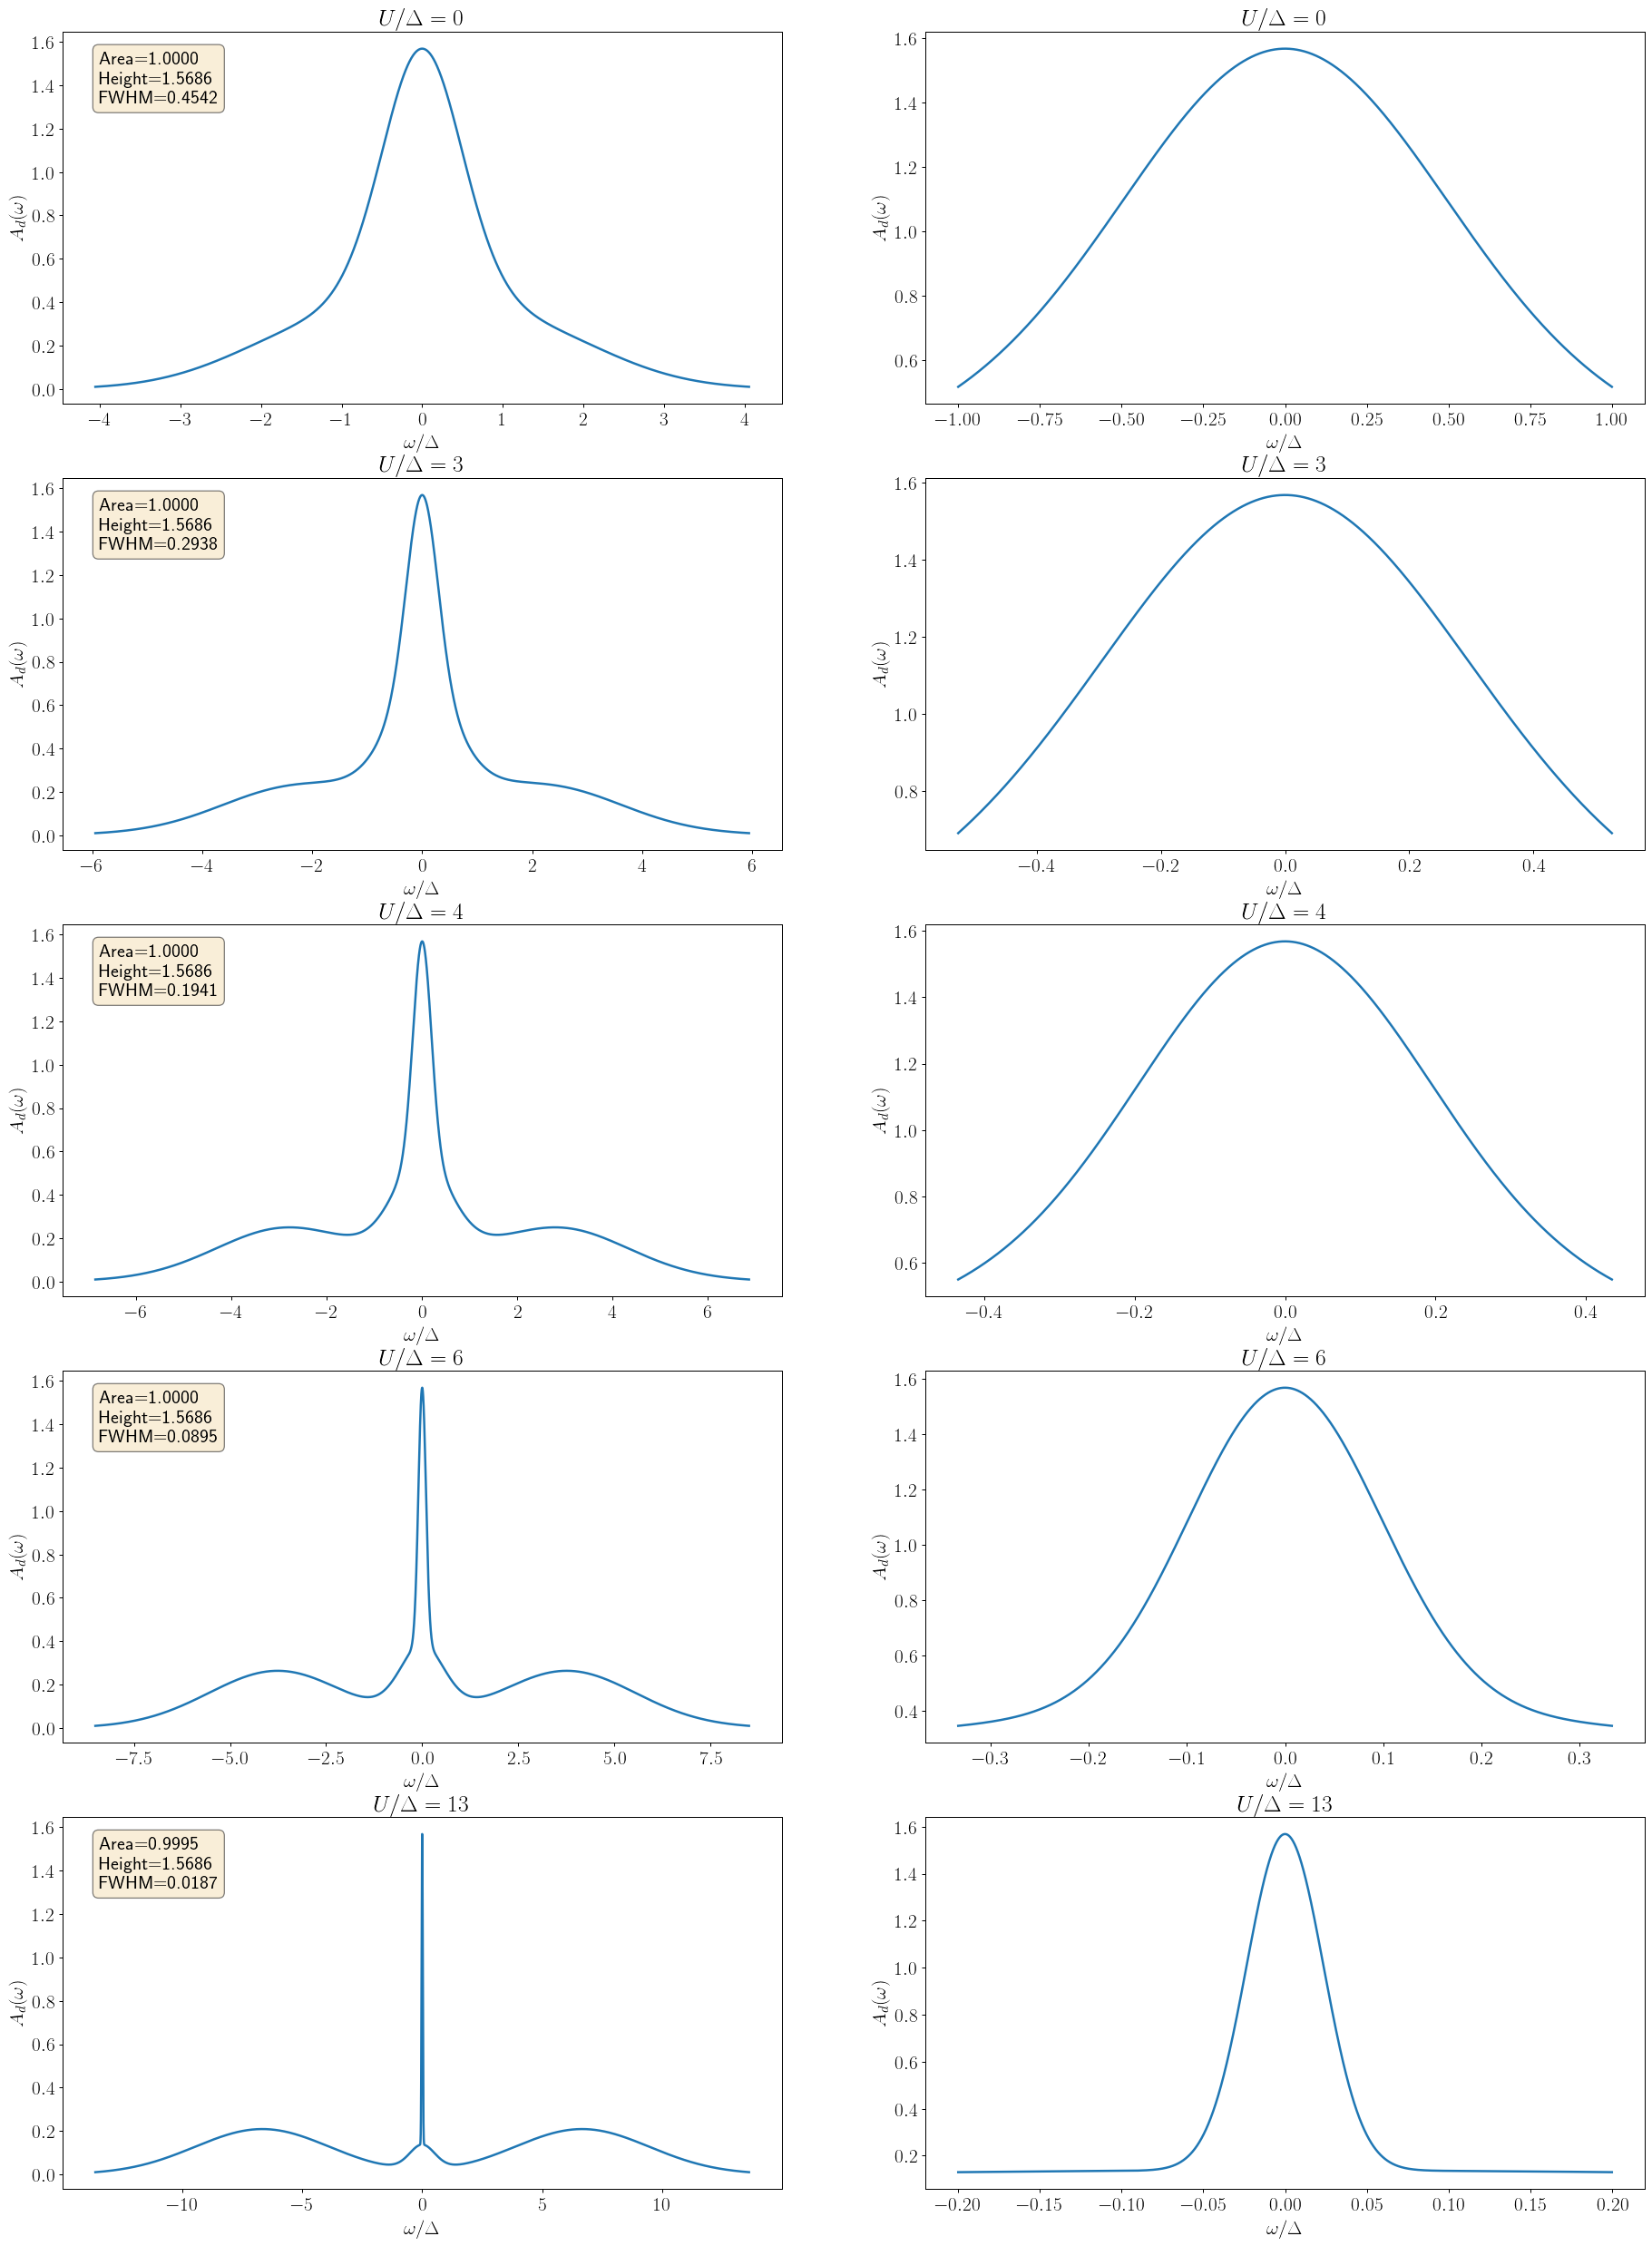

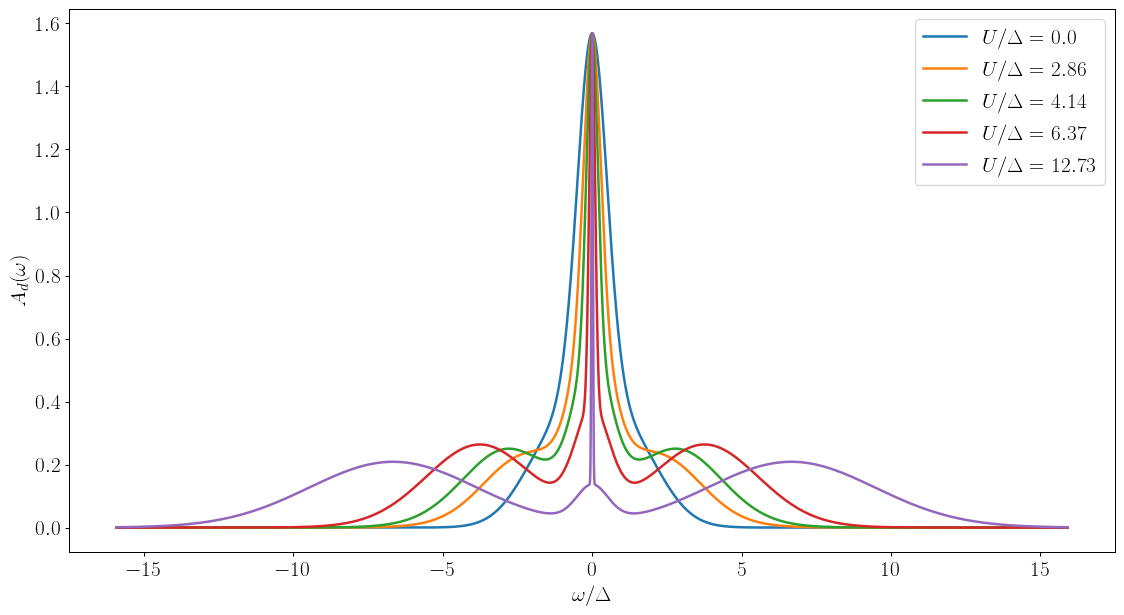

In [33]:
def get_rho_X(args):
    nfactor = 1
    wfactor = 1
    (En, Xn), Xgs, Egs, Z, hfactor, flag = args
#     eta = (4*t + np.sqrt(abs(w_range))*wfactor)/nfactor
    c0_up = tensor([identity(2), destroy(2)] + [identity(2)]*(len(Xgs.dims[0])-2))
    C1 = Xgs.dag()*c0_up*Xn
    C1_sq = np.real((C1*C1.dag())[0][0][0])
    C2 = Xn.dag()*c0_up*Xgs
    C2_sq = np.real((C2*C2.dag())[0][0][0])
    eta = 4*t*(1 + 2.5*abs(En - Egs))
    x1 = w_range + Egs - En
    x2 = w_range + En - Egs
    if flag == True:
        return En - Egs, (C1_sq * np.exp(-(x1/eta)**2)/(eta*sqrt(np.pi)) + C2_sq * np.exp(-(x2/eta)**2)/(eta*sqrt(np.pi))) / Z
    else:
        if abs(En - Egs) < w_cut:
            eta /= hfactor
        return (C1_sq * np.exp(-(x1/eta)**2)/(eta*sqrt(np.pi)) + C2_sq * np.exp(-(x2/eta)**2)/(eta*sqrt(np.pi))) / Z

    
def get_nonint_ht(Ek_0, V):
    U = 0
    ed = -U/2
    H = get_ham(Ek_0, V, ed, U)
    H = 0.5 * (H + H.dag())
    E, X = H.eigenstates()
    X0 = X[np.where(E == min(E))]
    A = sum(list(tqdm(Pool().map(get_rho_X, product(zip(E, X), X0, [E[0]], [len(X0)], [1], [False])), total=len(X0)*len(E))))
    A = 0.5*(A + np.flip(A))
    return A[np.where(w_range == 0)]
    
    
def get_correction_factor(E, X, h):
    X0 = X[np.where(E == min(E))]
    ar = np.zeros(2)
    wt = np.zeros(2)
    for pi, Ai in list(tqdm(Pool().map(get_rho_X, product(zip(E, X), X0, [E[0]], [len(X0)], [1], [True])), total=len(X0)*len(E))):
        if pi < w_cut:
            wt[0] += Ai[np.where(w_range == 0)]
            ar[0] += np.trapz(Ai, w_range)
        else:
            wt[1] += Ai[np.where(w_range == 0)]
            ar[1] += np.trapz(Ai, w_range)
    
    hfactor = abs(h - wt[1])/wt[0]
    return hfactor


def get_FWHM(w_range, A):
    w_half = w_range[(A <= max(A)) & (A>=max(A)/2)]
    return (max(w_half) - min(w_half))
    
    
V = 0.1
t = 0.05
delta = np.pi*V**2/(2*t)
Nk = 4
a = 1
k_bath = 2*np.pi*np.arange(0, Nk)/(a*Nk)
Ek_0 = -2*t*np.cos(k_bath*a)

w_end = 5
len_w = 20000
p = 6
w_half = np.linspace(0, w_end, len_w)**p/w_end**(p-1)
w_range = np.unique(np.concatenate([-w_half, w_half]))
w_cut = 10**(-4)

h = get_nonint_ht(Ek_0, V)

U_range = [0, 0.9, 1.3, 2, 4]
fig1, ax1 = plt.subplots(len(U_range),2, figsize=(25,7*len(U_range)))
fig2, ax2 = plt.subplots(figsize=(15,8))
ax2.set_xlabel(r"$\omega/\Delta$")
ax2.set_ylabel(r"$A_d(\omega)$")
for x,y in product(range(len(ax1)), range(len(ax1[0]))):
    ax1[x][y].set_xlabel(r"$\omega/\Delta$")
    ax1[x][y].set_ylabel(r"$A_d(\omega)$")
    ax1[x][y].set_title(r"$U/\Delta={}$".format(round(U_range[x]/delta),2))


i = -1
ht_area = []
hfactor = 1
nfactor = 1



for U in U_range:
    i += 1
    ed = -U/2
    H = get_ham(Ek_0, V, ed, U)
    H = 0.5 * (H + H.dag())
    E, X = H.eigenstates()
    X0 = X[np.where(E == min(E))]
    hfactor = get_correction_factor(E, X, h)
    A = sum(list(tqdm(Pool().map(get_rho_X, product(zip(E, X), X0, [E[0]], [len(X0)], [hfactor], [False])), total=len(X0)*len(E))))
    A = 0.5*(A + np.flip(A))
    maxA = max(A)
    area = np.trapz(A, w_range)
    fwhm = get_FWHM(w_range, A)
    textstr = '\n'.join((
    r'Area=%.4f' % np.trapz(A, w_range),
    r'Height=%.4f' % max(A),
    r'FWHM=%.4f' % get_FWHM(w_range, A)))
    prominent_range = np.where(A > 10**(-2))
    ax1[i][0].plot(w_range[prominent_range]/delta, A[prominent_range])
    ax1[i][1].plot(w_range[np.where(abs(w_range/delta) < 1/(1+U))]/delta, A[np.where(abs(w_range/delta) < 1/(1+U))])
    ax1[i][0].text(0.05, 0.95, textstr, transform = ax1[i][0].transAxes, size=17, verticalalignment='top', bbox=props, fontfamily="monospaced")
    ax2.plot(w_range/delta, A, label=r"$U/\Delta={}$".format(round(U/delta,2)))

    
ax2.legend()
fig1.savefig("merged.pdf", bbox_inches='tight')
fig2.savefig("merged_all.pdf", bbox_inches='tight')
plt.show()